Author: Max Boleininger

UK Atomic Energy Authority, 2024

# Casade damage and recrystallisation size models  
modified arc-dpa model:
> Q. Yang and P. Olsson. "Full energy range primary radiation damage model." 
Physical Review Materials 5 (2021): 073602

cascade melt model:
> M. Boleininger, D. R. Mason, A. E. Sand, and S. L. Dudarev "Microstructure of a heavily irradiated metal exposed to a spectrum of atomic recoils." 
Scientific Reports 13 (1) (2023): 1684

In [2]:
import os, glob
import numpy as np
import math
from matplotlib import pyplot as plt

import scipy

import matplotlib
from matplotlib.transforms import Bbox

from pathlib import Path
import sys  

# Get my_package directory path from Notebook
parent_dir = str(Path().resolve().parents[0])

# Add lib path to sys.path (needed to import the Lindhard model)
sys.path.insert(0, "%s/lib/" % parent_dir)

from lindhard import Lindhard

In [3]:
# minimum and angular-averaged threshold displacement energies for Nickel,
# obtained from getedenergy.py simulations, analysed with edenergy-alloy.ipynb
Ed_min, Ed = 16.7281, 25.7097

In [4]:
# Lindhard electronic stopping model for damage energy
# build model averaged over the chance of occurrence of the specific projectile and target elements model 
# order: Ni Fe Cr
A = {0: 58.6934, 1: 55.845, 2: 51.9961} # atomic mass
Z = {0: 28, 1: 26, 2: 24}               # charge number
composition = [0.094, 0.714, 0.192]     # composition of the material 
nelements = 3                           # number of elements

# Lindhard models for all combinations of projectile and target species
tdmodels = {}
for i in range(nelements):
    for j in range(nelements):
        tdmodels[(i,j)] = Lindhard (A[i], A[j], Z[i], Z[j])

# Lindhard model averaged over abundance of target and projectile
def avg_tdmodel (pka):
    tdenergy = 0.0 
    for i in range(nelements):
        for j in range(nelements):
            tdenergy += composition[i]*composition[j]*tdmodels[(i,j)](pka)
    tdenergy *= 1/sum(composition)**2 # normalisation should not be needed, but do here just in case
    return tdenergy

stopping_cutoff = 10.0 # electronic stopping cutoff (eV) used in the ezcascades simulation

dE  = stopping_cutoff - avg_tdmodel(stopping_cutoff)
tdmodel = lambda epka: avg_tdmodel(epka) + dE if epka>stopping_cutoff else epka
tdmodel = np.vectorize(tdmodel)

In [5]:
# Primary radiation melt model
class MeltModel:
    def __init__(self, E0min, Edmin, b):
        self.Edmin = Edmin
        self.E0min = E0min
        self.b = b
        self._veccall = np.vectorize(self._call)
        
    def _call(self, Td):
        if Td <= self.E0min:
            return 0.
        elif Td < self.Edmin:
            return self.b/self.Edmin*Td*Td
        else:
            return self.b*Td
        
    def __call__(self, Td):
        return self._veccall(Td)

    
# Qigui Yang and Pär Olsson primary radiation damage model
class YangOlsson:
    def __init__(self, Edmin, Ed, b, c):
        self.Edmin = Edmin
        self.Ed = Ed
        self.b = b
        self.c = c
        self._cfunc = np.vectorize(self._call)
        
    def _chi(self, Td):
        return (1-self.c)/(2*self.Ed/0.8)**self.b * Td**self.b + self.c
    
    def _call(self, Td):
        if Td <= self.Edmin:
            return 0.
        elif Td < 2*self.Ed/0.8:
            return 0.8*Td/(2*self.Ed)
        else:
            return 0.8*Td/(2*self.Ed) * self._chi(Td)
        
    def __call__(self, Td):
        return self._cfunc(Td)

In [6]:
import re # regex used to remove nondigit from string

def fetch_cascade_stats(filenames, damagemodel):
    '''Extract Frenkel pair generation data'''
    
    # extract energies from file name
    eVs = [re.sub("\D", "",_f.replace('keV', '000').rstrip('eV.log').split('/')[-1]) for _f in filenames]
    eVs = np.array(eVs, dtype=float)

    _filenames = filenames[np.argsort(eVs)]
    recoilenergies = np.sort(eVs)

    damageenergies = damagemodel(recoilenergies)

    _raw = [np.loadtxt(_f)[:,0] for _f in _filenames]
    meandefects = [np.mean(_r) for _r in _raw]
    errdefects = [np.std(_r)/np.sqrt(len(_r)) for _r in _raw]

    return damageenergies, meandefects, errdefects

In [7]:
def fetch_melt_stats(filenames, damagemodel):
    '''Extract primary melt size data'''
    
    eVs = [re.sub("\D", "", _f.replace('keV', '000').replace('.', '/').split('/')[-3]) for _f in filenames]
    eVs = np.array(eVs, dtype=float)

    _filenames = np.array(fnames)[np.argsort(eVs)]
    recoilenergies = np.sort(eVs)
    recoilenergies, ix = np.unique(recoilenergies, return_index=True)
    damageenergeis = damagemodel(recoilenergies)

    _filenames = np.split(_filenames, ix)[1:]

    nmelt = [[np.max(np.loadtxt(_f)[:,1]) for _f in _fn] for _fn in _filenames]
    meanmelt = [np.mean(nm) for nm in nmelt]
    errmelt = [np.std(nm)/np.sqrt(len(nm)) for nm in nmelt]
    
    return damageenergeis, meanmelt, errmelt

In [8]:
# these FeNiCr file names are differently formatted, so we need to adjust the import routine
def fetch_cascade_stats_v2(filenames, damagemodel):
    # extract energies
    eVs = [_f.replace('keV', '000').rstrip('eV.log').split("cascade.")[-1] for _f in filenames]
    eVs = np.array(eVs, dtype=float)

    _filenames = filenames[np.argsort(eVs)]
    recoilenergies = np.sort(eVs)

    damageenergies = damagemodel(recoilenergies)

    _raw = [np.loadtxt(_f)[:,0] for _f in _filenames]
    meandefects = [np.mean(_r) for _r in _raw]
    errdefects = [np.std(_r)/np.sqrt(len(_r)) for _r in _raw]

    return damageenergies, meandefects, errdefects

def fetch_melt_stats_v2(filenames, damagemodel):
    
    eVs = [_f.replace('keV', '000').rstrip('.rec').split("melttest.")[-1].split("eV")[0] for _f in filenames]
    eVs = np.array(eVs, dtype=float)

    _filenames = np.array(fnames)[np.argsort(eVs)]
    recoilenergies = np.sort(eVs)
    recoilenergies, ix = np.unique(recoilenergies, return_index=True)
    damageenergeis = damagemodel(recoilenergies)

    _filenames = np.split(_filenames, ix)[1:]

    nmelt = [[np.max(np.loadtxt(_f)[:,1]) for _f in _fn] for _fn in _filenames]
    meanmelt = [np.mean(nm) for nm in nmelt]
    errmelt = [np.std(nm)/np.sqrt(len(nm)) for nm in nmelt]
    
    return damageenergeis, meanmelt, errmelt

In [9]:
# fetch cascade defect data 
fnames = glob.glob("./example-data/FeNiCr_cascade.*.log")
fnames = np.array(fnames)

tddefects, meandefects, errdefects = fetch_cascade_stats_v2 (fnames, tdmodel)

In [10]:
# fetch cascade melt data
fnames = glob.glob("./example-data/melttest.*.rec")

tdmelt, meanmelt, errmelt = fetch_melt_stats_v2 (fnames, tdmodel)

In [11]:
# use nonlinear model fit to obtain melting energy
ix = np.nonzero(meanmelt)[0][0]
emelt0 = tdmelt[ix]
print ("Lowest melting energy: melting on average %f atoms at %f eV recoil energy." % (meanmelt[ix], emelt0))
print ()

def melt_loss (melt_energy, tdrange, defectvals):
    # loss function
    meltmodel = MeltModel(emelt0, Ed_min, 1/melt_energy)
    residual = (defectvals - meltmodel(tdrange)) * 10 *((tdrange<1000.)+.1)
    return np.sqrt(np.sum(residual*residual))

res = scipy.optimize.minimize (melt_loss, (1.0), args=(tdmelt, meanmelt), tol=1e-1)
print (res)
emelt = res.x[0]

print ()
print ("Average cascade melting energy: %f eV" % emelt)

Lowest melting energy: melting on average 0.125000 atoms at 2.000000 eV recoil energy.

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1400.8008580186467
        x: [ 8.481e-01]
      nit: 4
      jac: [ 6.992e-02]
 hess_inv: [[ 6.209e-07]]
     nfev: 24
     njev: 12

Average cascade melting energy: 0.848073 eV


In [12]:
# use nonlinear model fit to obtain arc-dpa b and c parameters
def arcdpa_loss (pars, tdrange, defectvals):
    # loss function
    damagemodel = YangOlsson(Ed_min, Ed, pars[0],np.sqrt(pars[1]*pars[1]))
    residual = (defectvals - damagemodel(tdrange))
    return np.sqrt(np.sum(residual*residual))

ixf = (np.array(meandefects)>0)

res = scipy.optimize.minimize (arcdpa_loss, (-0.810, 0.25), args=(np.r_[tddefects][ixf], np.r_[meandefects][ixf]))
print (res)

bfitted = res.x[0]
cfitted = np.abs(res.x[1])

print ()
print ("Fitted b and c parameters for FeNiCr:", bfitted, cfitted)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 7.715933906653504
        x: [-8.631e-01  2.713e-01]
      nit: 8
      jac: [ 1.013e-06  7.331e-06]
 hess_inv: [[ 5.460e-02 -2.298e-03]
            [-2.298e-03  1.349e-04]]
     nfev: 36
     njev: 12

Fitted b and c parameters for FeNiCr: -0.863077712930417 0.2712512563955073


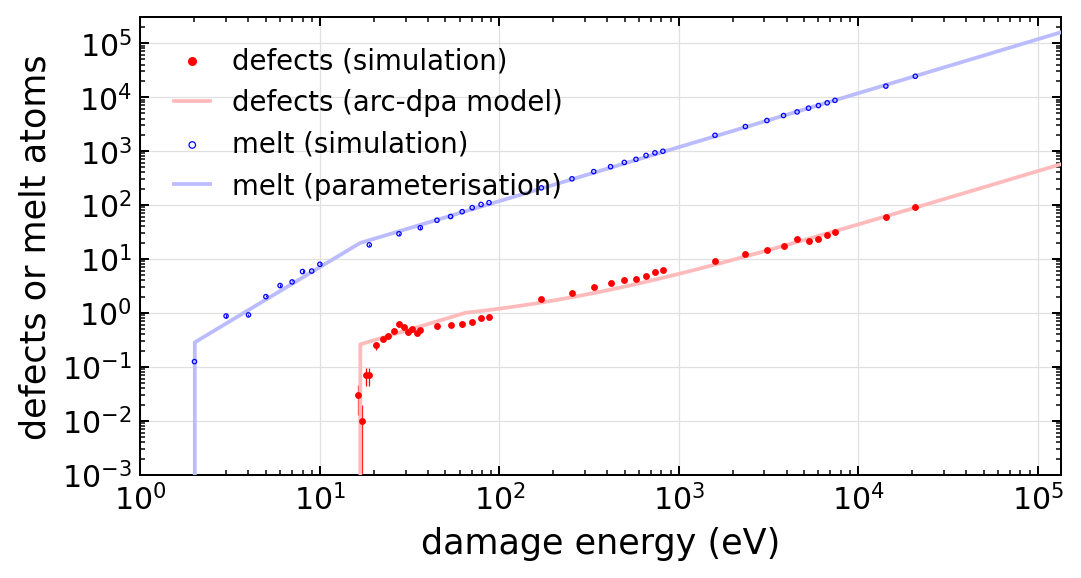

In [13]:
# Plot Fig
fig = plt.figure(figsize=(6.6, 3.3), dpi=180) 
ax = fig.add_subplot(1,1,1)

kwargs = {'s': 3, 'marker':'o', 'c':'r', 'zorder': 10}
ax.scatter(tddefects, meandefects, **kwargs, label="defects (simulation)")
ax.errorbar(tddefects, meandefects, yerr=errdefects, ls='None', lw=0.5, c='r')

# define YO-dpa model for FP generation over damage energy
yodpa = YangOlsson(Ed_min, Ed, bfitted, cfitted)

tdrange = 10**np.linspace(1,5.5,1000)
yvalsyodpa = yodpa(tdrange)
kwargs = {'c':'#ffbbbb', 'zorder': 5}
ax.plot(tdrange, yvalsyodpa, label="defects (arc-dpa model)", **kwargs)

# s = 8
kwargs = {'s': 3, 'lw': .5, 'marker':'o', 
          'edgecolors':'b', 'zorder': 10, 'c':'none'}
ax.scatter(tdmelt, meanmelt, **kwargs, label="melt (simulation)")
ax.errorbar(tdmelt, meanmelt, yerr=errmelt, ls='None', lw=0.5, c='b')

# define melt model function over damage energy
meltmodel = MeltModel(emelt0, Ed_min, 1/emelt)

tdrange = 10**np.linspace(0,5.5,1000)
yvalsmelt = meltmodel(tdrange)

kwargs = {'c':'#bbbbff', 'zorder': 5}
ax.plot(tdrange, yvalsmelt, label="melt (parameterisation)", **kwargs)


# xy labels
plt.xlabel("damage energy (eV)", fontsize=14)
plt.ylabel("defects or melt atoms", fontsize=14)

ax.tick_params(axis = 'both', which = 'major', direction='in', 
                    bottom=True, left=True, top=True, right=True, labelsize = 12)
ax.tick_params(axis = 'both', which = 'minor', direction='in', 
                    bottom=True, left=True, top=True, right=True, labelsize = 12)

# grid lines
ax.grid(True, lw=.5, zorder=3, c='#e0e0e0')

# axis limits 
ax.set_xscale('log')
ax.set_xlim(1e0, 1.35e5)

ax.set_yscale('log')
ax.set_ylim(1e-3, 3e5)


locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0),
                                                  numticks=20)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(0.0, 1.0), numticks=20)
ax.yaxis.set_major_locator(locmaj)


# add legend
ax.legend(frameon=False, fontsize=11, markerscale=1.5, 
         handlelength=1.3, loc='upper left', bbox_to_anchor=(0.01, .99))

plt.show()

# uncomment below to save figure
#fig.savefig('primarygeneration.pdf', dpi=1200, bbox_inches='tight', pad_inches=0.02)